In [61]:
import os
from os import listdir
import time

# Torch libs
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torch.utils.data.sampler import WeightedRandomSampler

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50
import torchvision.transforms as transforms
from torchvision.io import read_image

from sklearn.model_selection import train_test_split

# Data libs
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## EDA: 
Check if the image has a dog or not<br>
If yes, count number of dogs/faces

### Read a doggo

In [2]:
!pwd

/home/ec2-user/doggo_vision/experiments/chins


#### Chihuahua

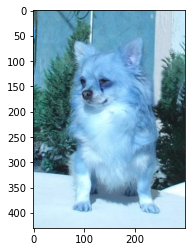

In [3]:
doggo_1 = cv2.imread('/home/ec2-user/doggo_vision/dogs/Images/n02085620-Chihuahua/n02085620_199.jpg')
plt.imshow(doggo_1)

#### Beagle

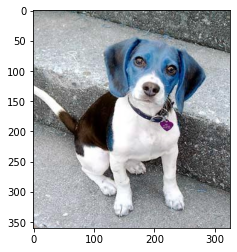

In [4]:
doggo_2 = cv2.imread('/home/ec2-user/doggo_vision/dogs/Images/n02088364-beagle/n02088364_2019.jpg')
plt.imshow(doggo_2)

## Cascade Classifier
(something new?)

### 1. Haar Cascade
Haar cascade function is trained from a lot of positive (faces) and negative (non-faces) human images

https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html

Download XML file from this GitHub repo:<br>
https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

In [5]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

#### 2. Count # of faces 

In [6]:
faces = face_cascade.detectMultiScale(doggo_1, 1.1, 4)

In [7]:
print("# of faces in doggo 1: ", len(faces))

# of faces in doggo 1:  1


### Object detection ("General" rule)

**No occurence:** If there is no face in the image, then the object is not present in the image

**> 1 occurence**: If there are more than one occurences of the object, we process each individual using a looping construct

In [8]:
if(len(faces)!=0):
    for (x, y, w, h) in faces: 
        cv2.rectangle(doggo_1, (x, y), (x+w, y+h), (255, 0, 0), 2)

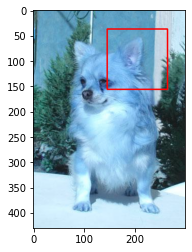

In [9]:
plt.imshow(doggo_1)

**NOTE:** The dataset has images that has a human face(s) along with dog face(s)

#### Detect images with dog + human faces

In [10]:
def detect_hooman(path):
    img = cv2.imread(path)
    # Convert to Grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    hooman_faces = face_cascade.detectMultiScale(gray_img)
    
    if(len(hooman_faces) > 0):
        return True
    return False

### 2. Doggo Cascade
This cascade function is trained from a lot of positive (faces) and negative (non-faces) human images

https://github.com/kskd1804/dog_face_haar_cascade

In [ ]:
doggo_cascade = cv2.CascadeClassifier('dog_cascade.xml')

^this is still a work in progress lol <br>
hopefully, someone creates a working XML doggo image to make it ezpz

## Neural Nets
(the OG way)

### Annotations
(what's this folder doing here? :P)

Annotation file is typically a XML file which looks quite similar to how HTML tags would look and what this file does is that it stores the metadata for respective images. <br>

The advantage of using the annotations file is that we don't need to manually count the # of images or calculate image dimensions and stuff

**Sample annotations file**

In [132]:
import xml.etree.ElementTree as ET
from pathlib import Path

# Chihuahua
path = '/home/ec2-user/doggo_vision/dogs/Annotation/n02085620-Chihuahua/n02085620_10074'

with open(path) as annot_file:
    print(''.join(annot_file.readlines()))

<annotation>
	<folder>02085620</folder>
	<filename>n02085620_10074</filename>
	<source>
		<database>ImageNet database</database>
	</source>
	<size>
		<width>333</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<segment>0</segment>
	<object>
		<name>Chihuahua</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>25</xmin>
			<ymin>10</ymin>
			<xmax>276</xmax>
			<ymax>498</ymax>
		</bndbox>
	</object>
</annotation>


In [41]:
import xml.etree.ElementTree as ET

tree = ET.parse('/home/ec2-user/doggo_vision/dogs/Annotation/n02085620-Chihuahua/n02085620_10074')
root = tree.getroot()

In [43]:
img_info = []

for node in root.iter('object'):
    name = node.find('name').text
    pose = node.find('pose').text

print("Name: ", name)
print("Pose: ", pose)

for node in root.iter('size'):
    width = int(node.find('width').text)
    height = int(node.find('height').text)
    depth = int(node.find('depth').text)
    
print("Width: ", width)
print("Height: ", height)
print("Depth: ", depth)

Name:  Chihuahua
Pose:  Unspecified
Width:  333
Height:  500
Depth:  3


**What's the info in `<bndbox>`?**

In [40]:
sample_annotations = []

for node in root.iter('bndbox'):
    xmin = int(node.find('xmin').text)
    ymin = int(node.find('ymin').text)
    xmax = int(node.find('xmax').text)
    ymax = int(node.find('ymax').text)

    sample_annotations.append([xmin, ymin, xmax, ymax])
    
print(sample_annotations)


[[25, 10, 276, 498]]


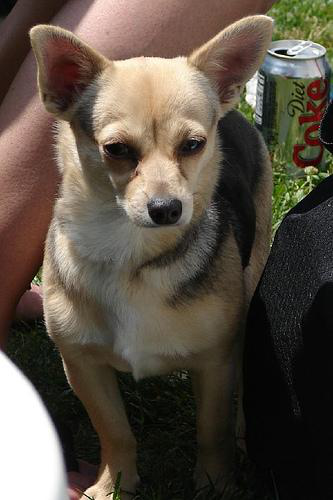

In [38]:
from PIL import Image, ImageDraw

sample_image = Image.open('/home/ec2-user/doggo_vision/dogs/Images/n02085620-Chihuahua/n02085620_10074.jpg')

sample_image

**Tadaaaa!** annotations give us the detected object directly! <br>
This is actally pre-computed info which helps us skip the step of **Object Detection** while performing EDA

[25, 10, 276, 498]


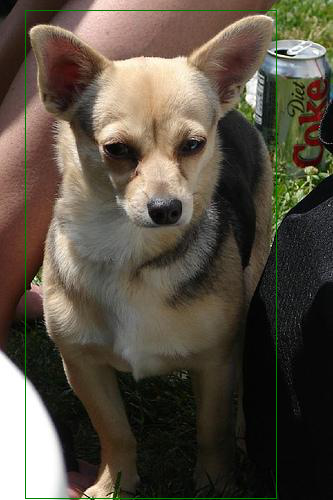

In [36]:
sample_image_annotated = sample_image.copy()

img_bbox = ImageDraw.Draw(sample_image_annotated)

for bbox in sample_annotations:
    print(bbox)
    img_bbox.rectangle(bbox, outline="green") 
    
sample_image_annotated

#### Create labels for each dog using the Annotations file

In [44]:
def get_doggo_info(file_path):
    for node in root.iter('object'):
        name = node.find('name').text
        pose = node.find('pose').text

    for node in root.iter('size'):
        width = int(node.find('width').text)
        height = int(node.find('height').text)
        depth = int(node.find('depth').text)
        
    for node in root.iter('bndbox'):
        xmin = int(node.find('xmin').text)
        ymin = int(node.find('ymin').text)
        xmax = int(node.find('xmax').text)
        ymax = int(node.find('ymax').text)

### 1. Using pre-trained image using `ImageNet` dataset

#### Check if CUDA is available to use

In [53]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

#### Create `labels` from Felix's code

In [11]:
os.chdir('/home/ec2-user/doggo_vision/dogs/Images')


labels = ['Chihuahua']
image_path = []
label_num = []

label_count = 0
for root, dirs, files in os.walk("."):
    for name in files:
#         print(os.path.join(root, name))
#         print(root.split("-",1)[1])
        
        labels.append(root.split("-",1)[1])
        image_path.append(os.path.join(root, name))
        
        if labels[-1] != labels[-2]:
            label_count += 1
        
        label_num.append(label_count)
        

df = pd.DataFrame({'labels':labels[1:],'image_path':image_path, 'label_num':label_num}) 

# Create label dict for later use
breeds = pd.Series(df.labels.values,index=df.label_num).to_dict()

# saving the dataframe 
df.to_csv('/home/ec2-user/doggo_vision/experiments/chins/labels.csv') 
display(df.head())
display(df.tail())

,labels,image_path,label_num
0,Chihuahua,./n02085620-Chihuahua/n02085620_10621.jpg,0
1,Chihuahua,./n02085620-Chihuahua/n02085620_10976.jpg,0
2,Chihuahua,./n02085620-Chihuahua/n02085620_11238.jpg,0
3,Chihuahua,./n02085620-Chihuahua/n02085620_11258.jpg,0
4,Chihuahua,./n02085620-Chihuahua/n02085620_11337.jpg,0


,labels,image_path,label_num
20575,French_bulldog,./n02108915-French_bulldog/n02108915_6142.jpg,119
20576,French_bulldog,./n02108915-French_bulldog/n02108915_623.jpg,119
20577,French_bulldog,./n02108915-French_bulldog/n02108915_9666.jpg,119
20578,French_bulldog,./n02108915-French_bulldog/n02108915_971.jpg,119
20579,French_bulldog,./n02108915-French_bulldog/n02108915_9899.jpg,119


In [12]:
# Test annotations
doggo_labels = pd.read_csv("/home/ec2-user/doggo_vision/experiments/chins/labels.csv")
index = 400
print("Index: ", doggo_labels.iloc[index, 0], "\nLabel: ", doggo_labels.iloc[index, 1], "\nImage directory: ", doggo_labels.iloc[index, 2], "\nLabel number: ", doggo_labels.iloc[index, 3])

print("\nTotal number of samples: ", doggo_labels.shape[0], "\nDog breeds/ unique labels: ", len(pd.unique(doggo_labels['labels'])))

# print("\nBreed value counts:", doggo_labels['labels'].value_counts())

print("\nNumber images per breed \nMax: ", max(doggo_labels['labels'].value_counts()), "\nMin:", min(doggo_labels['labels'].value_counts()))

Index:  400 
Label:  Maltese_dog 
Image directory:  ./n02085936-Maltese_dog/n02085936_426.jpg 
Label number:  2

Total number of samples:  20580 
Dog breeds/ unique labels:  120

Number images per breed 
Max:  252 
Min: 148


In [14]:
# Create train, validate and test with proportional classes
from sklearn.model_selection import train_test_split

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

label_num = np.array(doggo_labels.iloc[:, 3])

# labels
dataY = label_num

# features
dataX_dummy = range(len(label_num)) 

# train is now 75% of the entire data set
index_train, index_test, y_train, y_test = train_test_split(dataX_dummy, dataY, test_size=1 - train_ratio, stratify=dataY)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
index_val, index_test, y_val, y_test = train_test_split(index_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test) 


In [16]:
# Check indices work
img_annotations = pd.read_csv("../../experiments/chins/labels.csv").iloc[index_train]
display(img_annotations.head())
print(img_annotations.iloc[0,2])
print(img_annotations.iloc[1,2])

,Unnamed: 0,labels,image_path,label_num
10012,10012,Labrador_retriever,./n02099712-Labrador_retriever/n02099712_7664.jpg,55
9313,9313,Lhasa,./n02098413-Lhasa/n02098413_3899.jpg,51
18076,18076,chow,./n02112137-chow/n02112137_517.jpg,104
17609,17609,Samoyed,./n02111889-Samoyed/n02111889_16283.jpg,102
13639,13639,Bouvier_des_Flandres,./n02106382-Bouvier_des_Flandres/n02106382_765...,79


./n02099712-Labrador_retriever/n02099712_7664.jpg
./n02098413-Lhasa/n02098413_3899.jpg


#### Using same Dataset class and config as Felix

#### Different ways to optimize
1. Optimal way to crop the image
2. Changing number of channels - Grayscale, RGB, CMYK
3. Normalize the tensor - either with 0s/1s or with mean/variance 

**TODO:** Some images have channels > 4 which will cause issues while using the pre-trained ResNet50 model which is trained on images with 3 channels.<br>
    
_Ways to rectify:_<br>
    1. Convert channel 4 to Grayscale (2)<br>
    2. Convert Grayscale (2) to RBG (3)<br>

In [136]:
class DoggoDataset(Dataset):
    def __init__(self, indices, transform=None):
        self.img_annotations = pd.read_csv("../../experiments/chins/labels.csv").iloc[indices]
        # Convert to Grayscale and crop it to 120x120
        self.transform = transforms.Compose([
            transforms.Resize((120,120)),
            # transforms.Grayscale(),
            transforms.ToTensor()
            # transforms.Normalize((0, 0, 0),(1, 1, 1))
        ])

    def __len__(self):
        return len(self.img_annotations)

    def __getitem__(self, idx):
        img_path = self.img_annotations.iloc[idx, 2]
        image = Image.open(img_path)
        label = self.img_annotations.iloc[idx, 3]

        if self.transform:
            image = self.transform(image)

        return image, label

### `DataLoader()`

#### Adding an extra parameter `num_workers`

`num_workers` can be decided based off of # of cores on the EC2 instance<br>
I'm currently using **p2.xlarge** instance which has 4 CPU cores

Doubling the `batch_size` to 128 since we're using CUDA on a GPU instance

In [137]:
train_set = DoggoDataset(index_train)
val_set = DoggoDataset(index_val)
test_set = DoggoDataset(index_test)

# num_workers=4
train_dataloader = DataLoader(train_set, batch_size=128, num_workers=4, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=128, num_workers=4, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=128, num_workers=4, shuffle=True)

### Custom functions
to make stuff modular

#### 1. Accuracy

In [138]:
def get_accuracy(pred, true):
    # Converting pred to 0 or 1
    pred = [1 if pred[i] >= 0.5 else 0 for i in range(len(pred))]

    # Calculating accuracy by comparing predictions with true labels
    acc = [1 if pred[i] == true[i] else 0 for i in range(len(pred))]
    
    # Compute accuracy
    acc = np.sum(acc) / len(pred)
    
    return (acc * 100)

#### 2. Train the model over one epoch

In [152]:
def train_one_epoch(train_dataloader):
    
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    for images, labels in train_dataloader:
        
        # ResNet is trained on images with only 3 channels
        if(images.shape[1] == 3):
            
            # Load images and labels to device - in our case GPU!
            images = images.to(device)
            # print(images.shape)
            labels = labels.to(device)
            # print(labels.shape)
            labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
            labels = labels.to(torch.float32)
        
            # Reseting Gradients
            optimizer.zero_grad()

            # Forward
            preds = model(images)

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            acc = get_accuracy(preds, labels)
            epoch_acc.append(acc)

            # Backward
            _loss.backward()
            optimizer.step()
    
    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    # Log the results
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time

#### 3. Validate the model over one epoch

In [153]:
def val_one_epoch(val_dataloader, best_val_acc):
    
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    for images, labels in val_dataloader:
        
        # ResNet is trained on images with only 3 channels
        if(images.shape[1] == 3):
        
            # Load images and labels to device - again GPU!
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
            labels = labels.to(torch.float32)

            # Forward
            preds = model(images)

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            acc = get_accuracy(preds, labels)
            epoch_acc.append(acc)
    
    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    # Log the results
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    # Save the best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc
        

## `ResNet50`
Let's gooooooo

In [147]:
model = resnet50(pretrained = True)

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

In [148]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Model stuff

In [154]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

# Loss Function
criterion = nn.BCELoss()

# Logs
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 10

In [155]:
best_val_acc = 0 # this will be computed in the validation step

for epoch in range(epochs):
    
    # Training
    loss, acc, _time = train_one_epoch(train_dataloader)
    
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    # Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_dataloader, best_val_acc)
    
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))

RuntimeError: Caught RuntimeError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 56, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 120, 120] at entry 0 and [4, 120, 120] at entry 42


### TODO:

1. Dockerize the entire codebase
2. Use Tensorflow serving to fetch the latest trained model instead of training every time
3. Compare the performance of ResNet34, VGG-16 and a few more architectures with ResNet